In [1]:
import os
import io

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageDraw, ImageFont
from six import BytesIO
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

2021-10-06 14:28:12.970642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-06 14:28:12.970662: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [23]:
BATCH_SIZE = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [24]:
#!python xml_to_csv_FC.py

In [25]:
paths = list([str(p) for p in Path('train').glob('*.jpg')])
paths

['train/D-1M05-5.tiff-Secondary-15695.5760-16859.6866.jpg',
 'train/D-1M03-4.tiff-Secondary-11021.1927-12192.2812.jpg',
 'train/D-1M04-4.tiff-Secondary-6486.683-7755.1974.jpg',
 'train/D-1M01-3.tiff-Secondary-104.2400-1191.3514.jpg',
 'train/D-1M05-3.tiff-Secondary-10296.467-11496.1834.jpg',
 'train/D-1M06-2.tiff-Secondary-1067.3455-2648.4831.jpg',
 'train/D-1M02-1.tiff-Secondary-6729.2955-7722.4103.jpg',
 'train/D-1M02-1.tiff-Secondary-407.4485-1443.5645.jpg',
 'train/D-1M05-5.tiff-Secondary-3549.8549-4711.9681.jpg',
 'train/D-1M05-5.tiff-Secondary-14256.7858-15678.9286.jpg',
 'train/D-1M05-1.tiff-Secondary-3492.9419-4833.10757.jpg',
 'train/D-1M01-2.tiff-Secondary-1754.414-3182.1887.jpg',
 'train/D-1M06-4.tiff-Secondary-6010.9181-7593.10675.jpg',
 'train/D-1M04-5.tiff-Secondary-13834.376-15374.1832.jpg',
 'train/D-1M03-5.tiff-Secondary-6700.9677-7645.11182.jpg',
 'train/D-1M05-1.tiff-Secondary-8732.404-10183.1886.jpg',
 'train/D-1M03-6.tiff-Secondary-16531.4176-17834.5525.jpg',
 'tra

In [26]:
def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  image_np = np.array(image.getdata(), dtype=np.uint8)
  return image_np.reshape((im_height, im_width, 3))

In [27]:
im = load_image_into_numpy_array(paths[0])

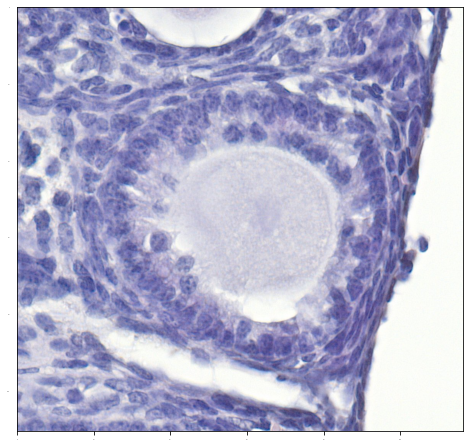

In [28]:
plt.imshow(im)

In [29]:
images_np = [load_image_into_numpy_array(str(p)) for p in paths]
len(images_np)

76

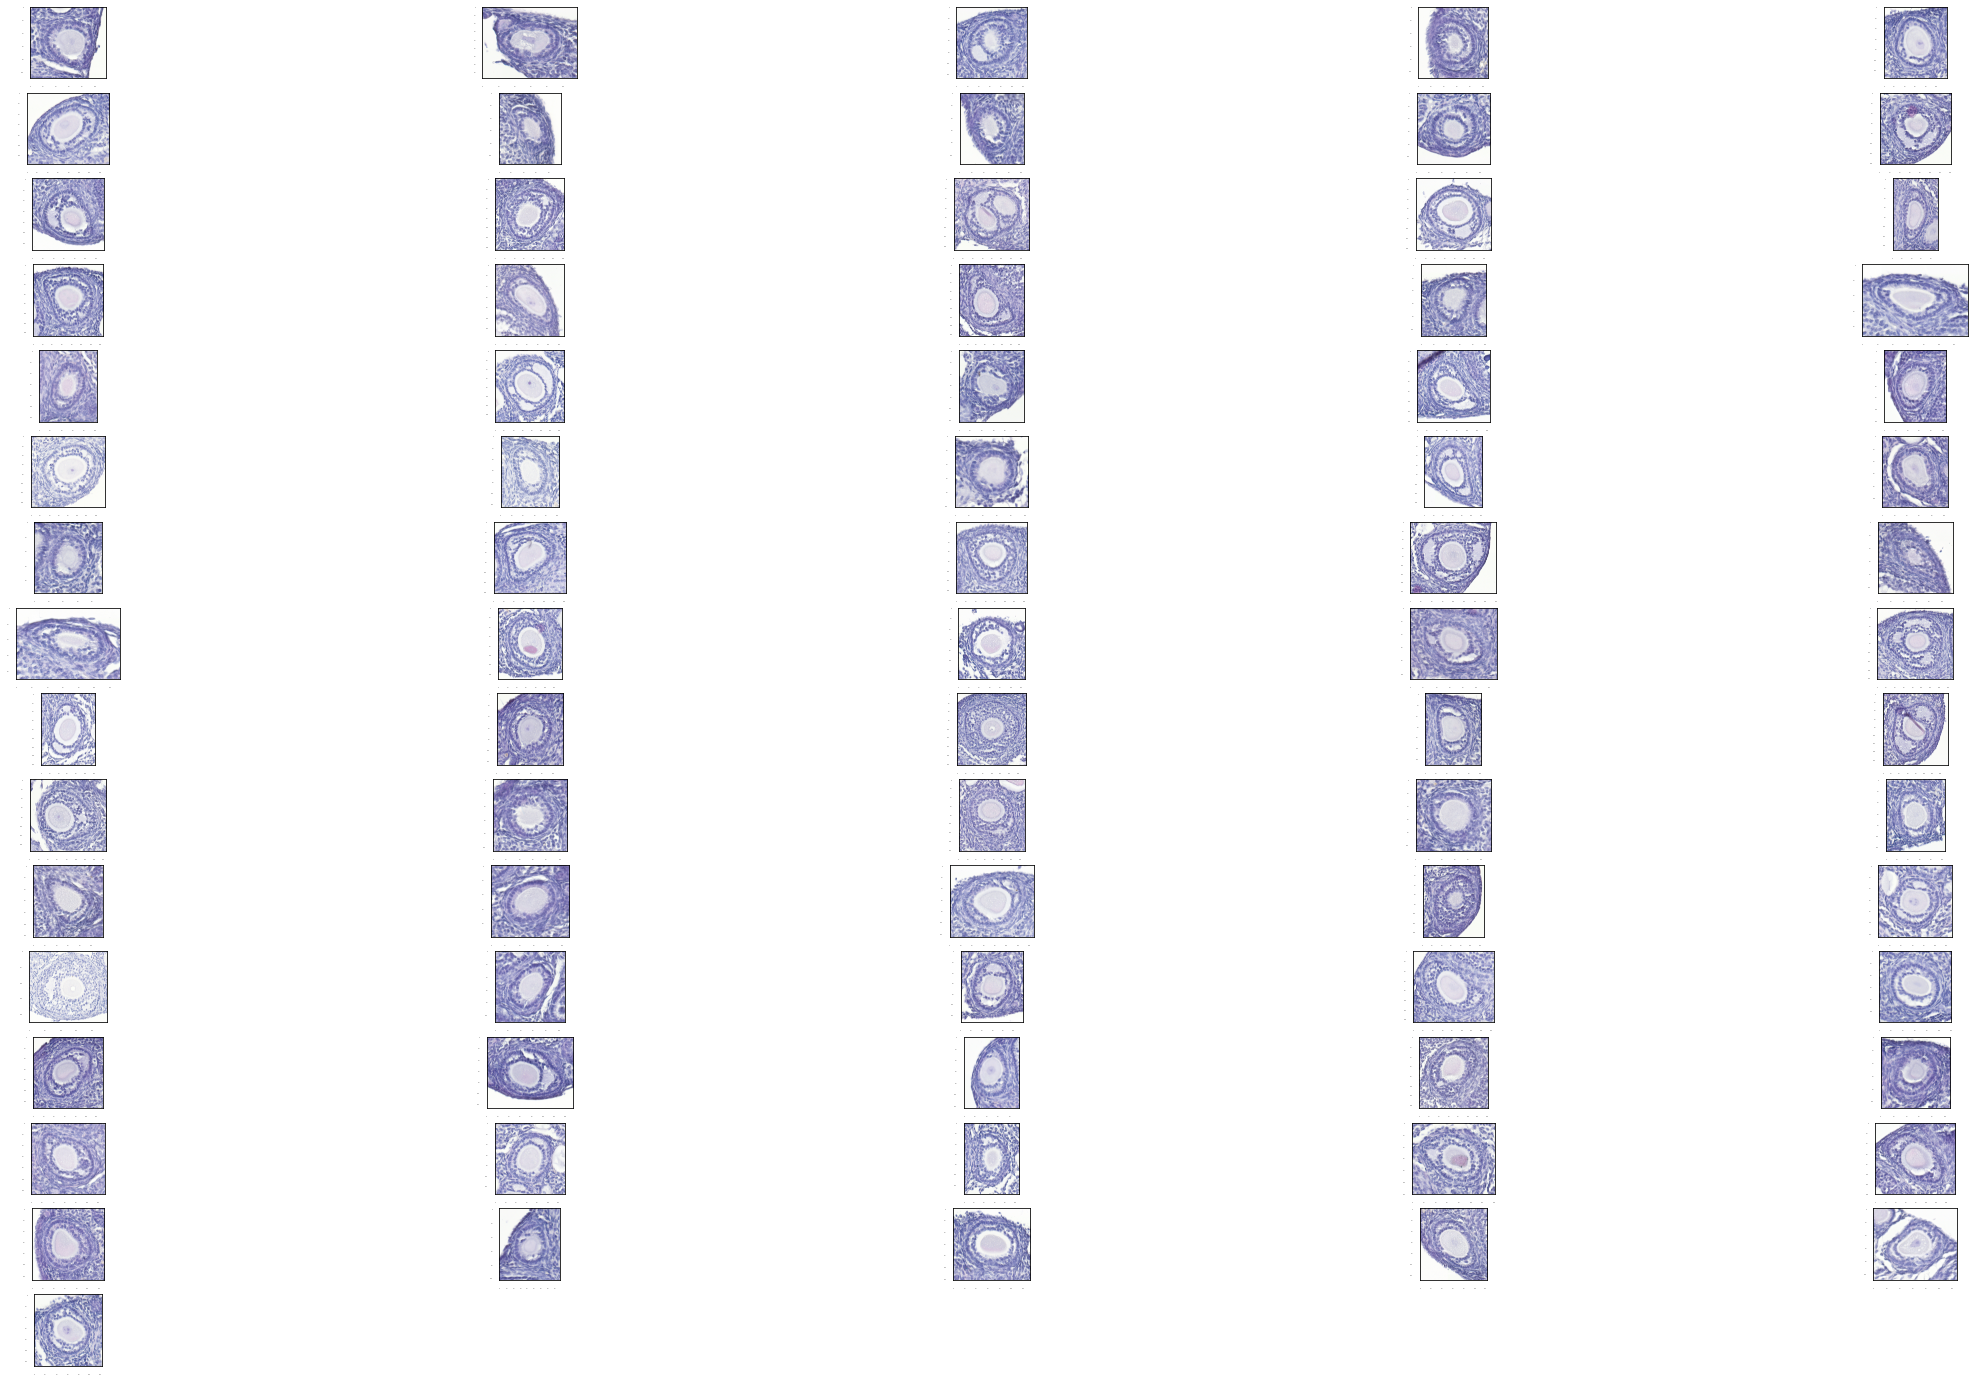

In [30]:
# Load images and visualize

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [40, 25]

for idx, image_np in enumerate(images_np):
  plt.subplot(16, 5, idx+1)
  plt.imshow(image_np)
plt.show()

In [31]:
from tensorflow.python.framework.versions import VERSION
if VERSION >= "2.0.0a0":
    import tensorflow.compat.v1 as tf
else:
    import tensorflow as tf

In [32]:
flags = tf.app.flags
flags.DEFINE_string('csv_input', './train_labels', 'Path to the CSV input')
flags.DEFINE_string('output_path', './train_TFRecord', 'Path to output TFRecord')
flags.DEFINE_string('image_dir', './train', 'Path to images')
tf.app.flags.DEFINE_string('f', '', 'kernel')
FLAGS = flags.FLAGS

In [33]:
import sys
sys.argv = sys.argv[:1]
print(FLAGS.output_path)

./train_TFRecord


In [34]:
def class_text_to_int(row_label):
    if row_label == 'Negative':
        return 1
    elif row_label == 'Primordial':
        return 2
    elif row_label == 'Primary':
        return 3
    elif row_label == 'Secondary':
        return 4
    elif row_label == 'Tertiary':
        return 5
    elif row_label == 'Atretic':
        return 6 
    else:
        return None

In [35]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [36]:
def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [37]:
train_examples = pd.read_csv("train_labels.csv")
train_examples

filename  width  height  \
0      D-1M02-1.tiff-Secondary-407.4485-1443.5645.jpg   1036    1160   
1     D-1M03-6.tiff-Secondary-6256.8565-7291.9847.jpg   1035    1282   
2     D-1M06-5.tiff-Secondary-1823.2911-3001.4183.jpg   1178    1272   
3     D-1M05-5.tiff-Secondary-3549.8549-4711.9681.jpg   1162    1132   
4     D-1M04-4.tiff-Secondary-9630.123-10851.1418.jpg   1221    1295   
..                                                ...    ...     ...   
71    D-1M06-2.tiff-Secondary-1067.3455-2648.4831.jpg   1581    1376   
72    D-1M07-4.tiff-Secondary-7724.1099-9236.2754.jpg   1512    1655   
73     D-1M06-5.tiff-Secondary-3869.901-5190.2256.jpg   1321    1355   
74   D-1M03-5.tiff-Secondary-7792.9523-9111.10614.jpg   1319    1091   
75  D-1M05-5.tiff-Secondary-14256.7858-15678.9286.jpg   1422    1428   

        class  xmin  ymin  xmax  ymax  
0   Secondary   214   198   834   965  
1   Secondary   171   200   867  1097  
2   Secondary   199   201   990  1092  
3   Secondary   213   187   950   936  
4   Secondary   175   188  1035  1107  
..        ...   ...   ...   ...   ...  
71  Secondary   203   217  1374  1184  
72  Secondary   196   205  1289  1453  
73  Secondary   189   206  1130  1174  
74  Secondary   196   192  1142   891  
75  Secondary   239   212  1237  1214  

[76 rows x 8 columns]

In [38]:
grouped = split(train_examples, 'filename')
grouped[1][1]

filename  width  height      class  \
42  D-1M01-2.tiff-Secondary-524.1917-1675.3009.jpg   1151    1092  Secondary   

    xmin  ymin  xmax  ymax  
42   197   192   934   903

In [39]:
# write TFRecord file
writer = tf.io.TFRecordWriter(FLAGS.output_path)
path = os.path.join(FLAGS.image_dir)
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
writer.close()

In [40]:
import tensorflow as tf
def parse_fn(data_record):
    features = {'image/encoded': tf.io.FixedLenFeature([], tf.string),
                'image/width': tf.io.VarLenFeature(dtype=tf.int64),
                'image/height': tf.io.VarLenFeature(dtype=tf.int64),
                'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
                'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
                'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
                'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
                'image/object/class/text': tf.io.VarLenFeature(dtype=tf.string),
                'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64)}
    sample = tf.io.parse_single_example(data_record, features)
    return sample

In [41]:
file_path_train = r'./train_TFRecord'

In [42]:
dataset_train = tf.data.TFRecordDataset([file_path_train])

In [43]:
type(dataset_train)

tensorflow.python.data.ops.readers.TFRecordDatasetV2

In [44]:
for record in dataset_train.take(1):
  example = tf.train.Example()
  example.ParseFromString(record.numpy())
  #print(example)

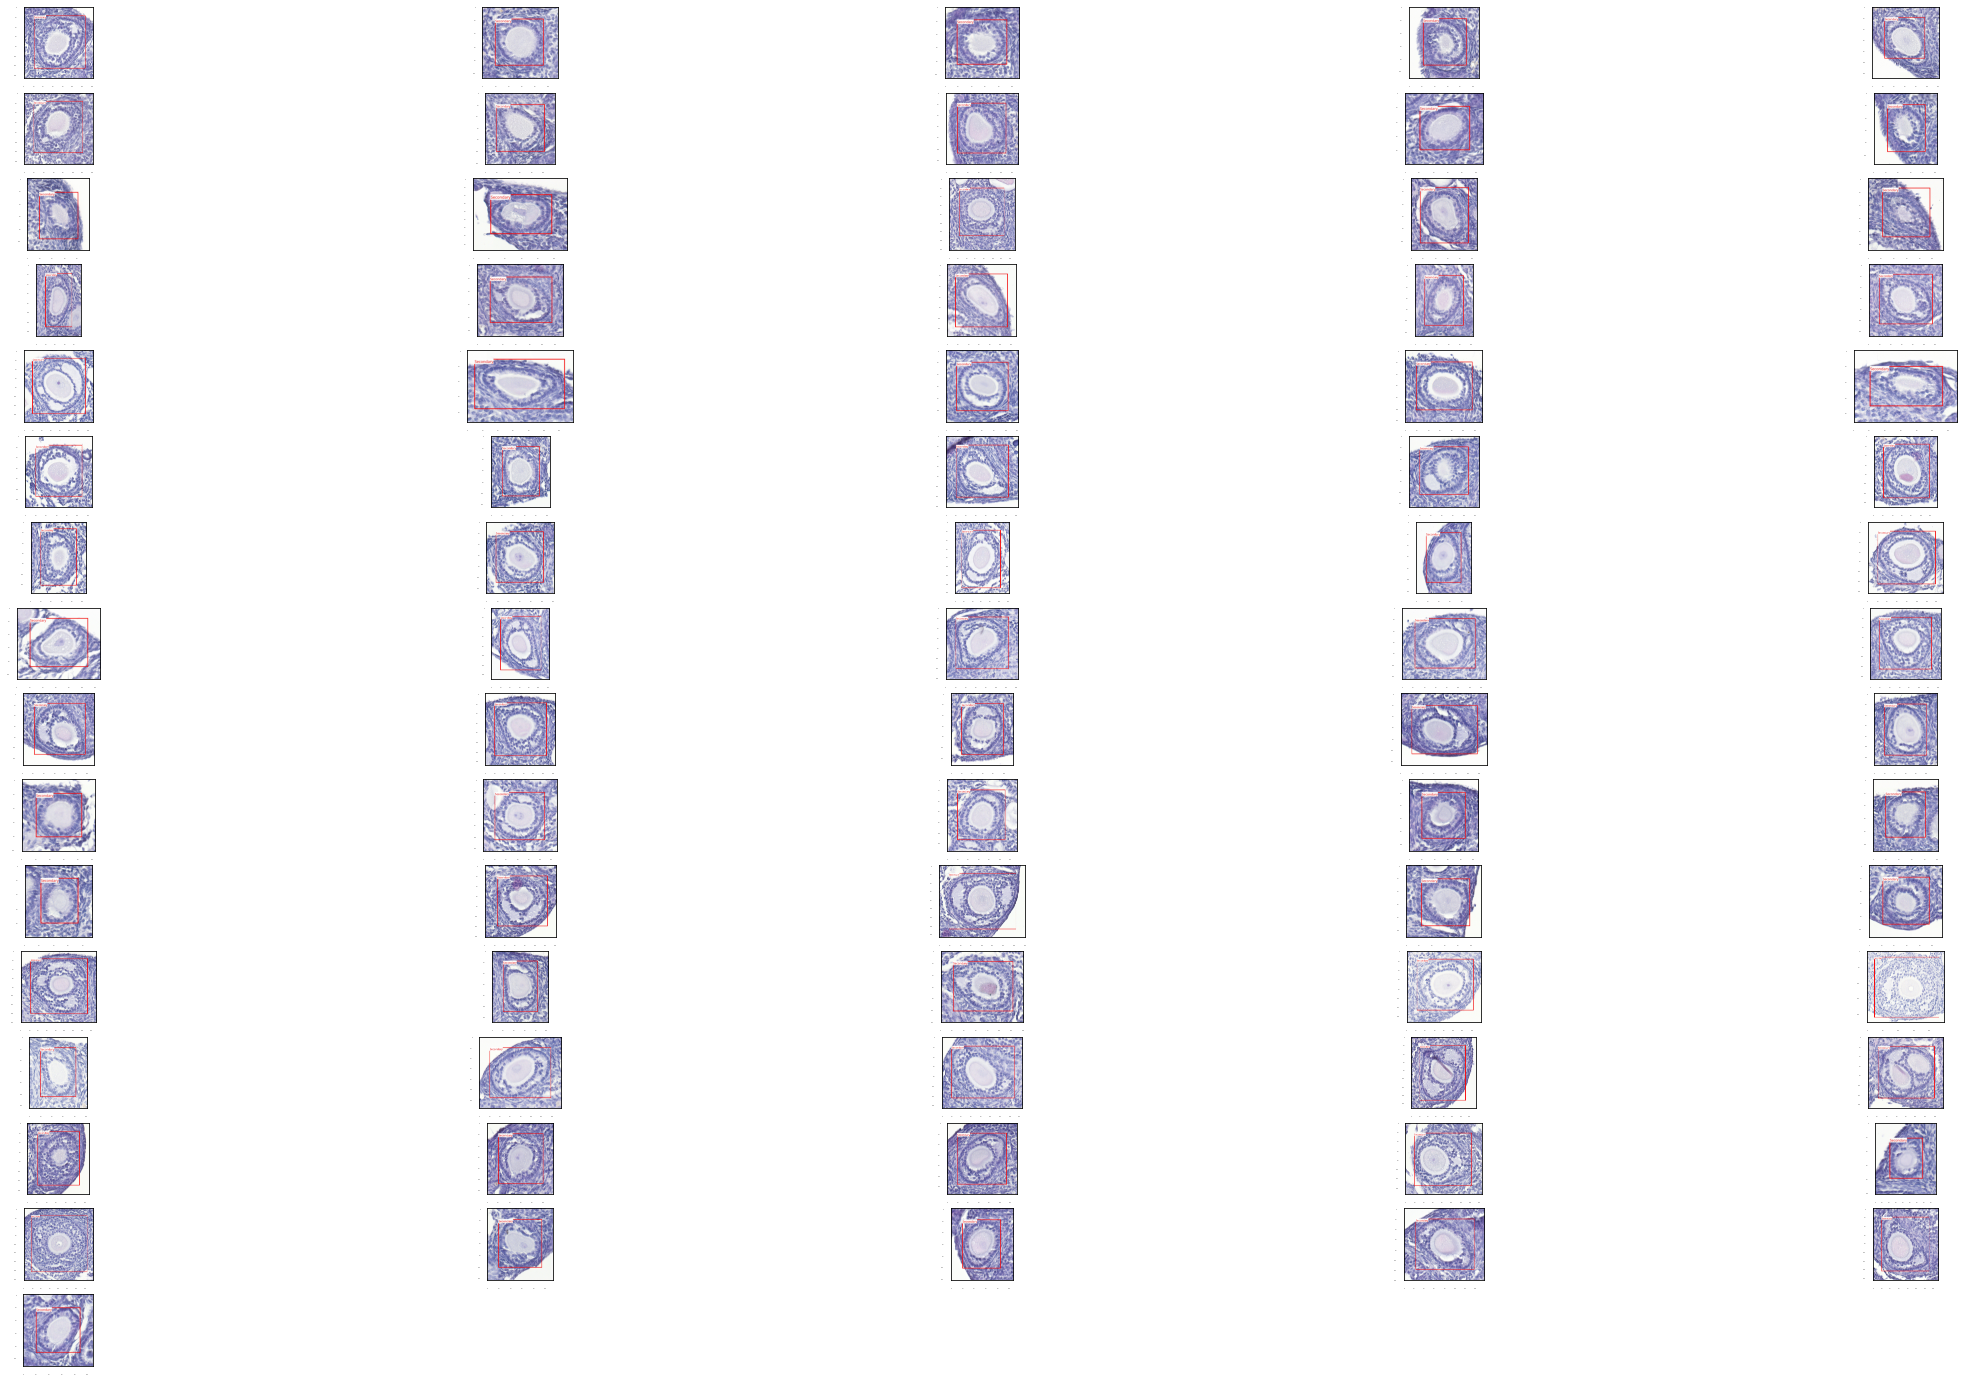

In [45]:
for idx, elem in enumerate(dataset_train):
    # Read and parse record
    parsed_example = parse_fn(elem)
    # Get im_width and im_height
    im_width = tf.sparse.to_dense(parsed_example['image/width']).numpy()[0]
    im_height = tf.sparse.to_dense(parsed_example['image/height']).numpy()[0]
    # Get label and bboxes coordinates
    labels = []
    for label in tf.sparse.to_dense(parsed_example['image/object/class/label']).numpy():
        labels.append(label)
    xmins = []
    for xmin in tf.sparse.to_dense(parsed_example['image/object/bbox/xmin']).numpy():
        xmins.append(xmin*im_width)
    ymins = []
    for ymin in tf.sparse.to_dense(parsed_example['image/object/bbox/ymin']).numpy():
        ymins.append(ymin*im_height)
    xmaxes = []
    for xmax in tf.sparse.to_dense(parsed_example['image/object/bbox/xmax']).numpy():
        xmaxes.append(xmax*im_width)
    ymaxes = []
    for ymax in tf.sparse.to_dense(parsed_example['image/object/bbox/ymax']).numpy():
        ymaxes.append(ymax*im_height)
    # Get texts
    texts = []
    for text in tf.sparse.to_dense(parsed_example['image/object/class/text']).numpy():
        text = text.decode('UTF-8')
        texts.append(text)
    # Convert encoded image to bytes then to JpegImageFile
    encoded_image = parsed_example['image/encoded']
    img_data = encoded_image.numpy()
    img = Image.open(BytesIO(img_data))
    # Draw image and bboxes
    draw = ImageDraw.Draw(img)
    for i in range(len(labels)):
        draw.rectangle((xmins[i], ymins[i], xmaxes[i], ymaxes[i]), outline="red", width=10)
    # Draw label text
    font = ImageFont.truetype("./OpenSans-Regular.ttf", 50)
    for i in range(len(labels)):
        w, h = font.getsize(texts[i])
        draw.rectangle((xmins[i], ymins[i], xmins[i] + w + 4, ymins[i] + h), fill="white")
        draw.text((xmins[i]+4, ymins[i]), texts[i], fill='red', font=font)
    # Display image
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        output_image = output.getvalue()
    image = Image.open(BytesIO(output_image))
    plt.subplot(16, 5, idx+1)
    plt.imshow(image)
plt.show()

# TEST images

In [46]:
from tensorflow.python.framework.versions import VERSION
if VERSION >= "2.0.0a0":
    import tensorflow.compat.v1 as tf
else:
    import tensorflow as tf

In [47]:
flags = tf.app.flags
flags.DEFINE_string('csv_input_test', './test_labels', 'Path to the test CSV input')
flags.DEFINE_string('output_path_test', './test_TFRecord', 'Path to test output TFRecord')
flags.DEFINE_string('image_dir_test', './test', 'Path to test images')
tf.app.flags.DEFINE_string('f_test', '', 'kernel')
FLAGS = flags.FLAGS

In [48]:
examples_test = pd.read_csv("test_labels.csv")
examples_test

filename  width  height       class  xmin  ymin  xmax  ymax
0  D-1M01-2.jpg   4389    4225    Negative  1665  2602  2745  3800
1  D-1M01-2.jpg   4389    4225    Negative   925  3203  1388  3773
2  D-1M01-2.jpg   4389    4225  Primordial   404  2191   541  2321
3  D-1M01-2.jpg   4389    4225     Primary  3024  2374  3625  2747
4  D-1M01-2.jpg   4389    4225    Negative  2760  2585  3609  3338
5  D-1M01-2.jpg   4389    4225   Secondary   724  2117  1475  2809
6  D-1M01-2.jpg   4389    4225   Secondary  1954   614  2982  1687
7  D-1M01-2.jpg   4389    4225   Secondary  1070   550  1777  1218
8  D-1M01-2.jpg   4389    4225    Negative   653  3150   829  3302

In [49]:
grouped_test = split(examples_test, 'filename')
grouped_test[0][1]

filename  width  height       class  xmin  ymin  xmax  ymax
0  D-1M01-2.jpg   4389    4225    Negative  1665  2602  2745  3800
1  D-1M01-2.jpg   4389    4225    Negative   925  3203  1388  3773
2  D-1M01-2.jpg   4389    4225  Primordial   404  2191   541  2321
3  D-1M01-2.jpg   4389    4225     Primary  3024  2374  3625  2747
4  D-1M01-2.jpg   4389    4225    Negative  2760  2585  3609  3338
5  D-1M01-2.jpg   4389    4225   Secondary   724  2117  1475  2809
6  D-1M01-2.jpg   4389    4225   Secondary  1954   614  2982  1687
7  D-1M01-2.jpg   4389    4225   Secondary  1070   550  1777  1218
8  D-1M01-2.jpg   4389    4225    Negative   653  3150   829  3302

In [56]:
# write test TFRecord file
writer = tf.io.TFRecordWriter(FLAGS.output_path_test)
path = os.path.join(FLAGS.image_dir_test)
for group in grouped_test:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
writer.close()

In [57]:
file_path_test = r'./test_TFRecord'

In [58]:
dataset_test = tf.data.TFRecordDataset([file_path_test])

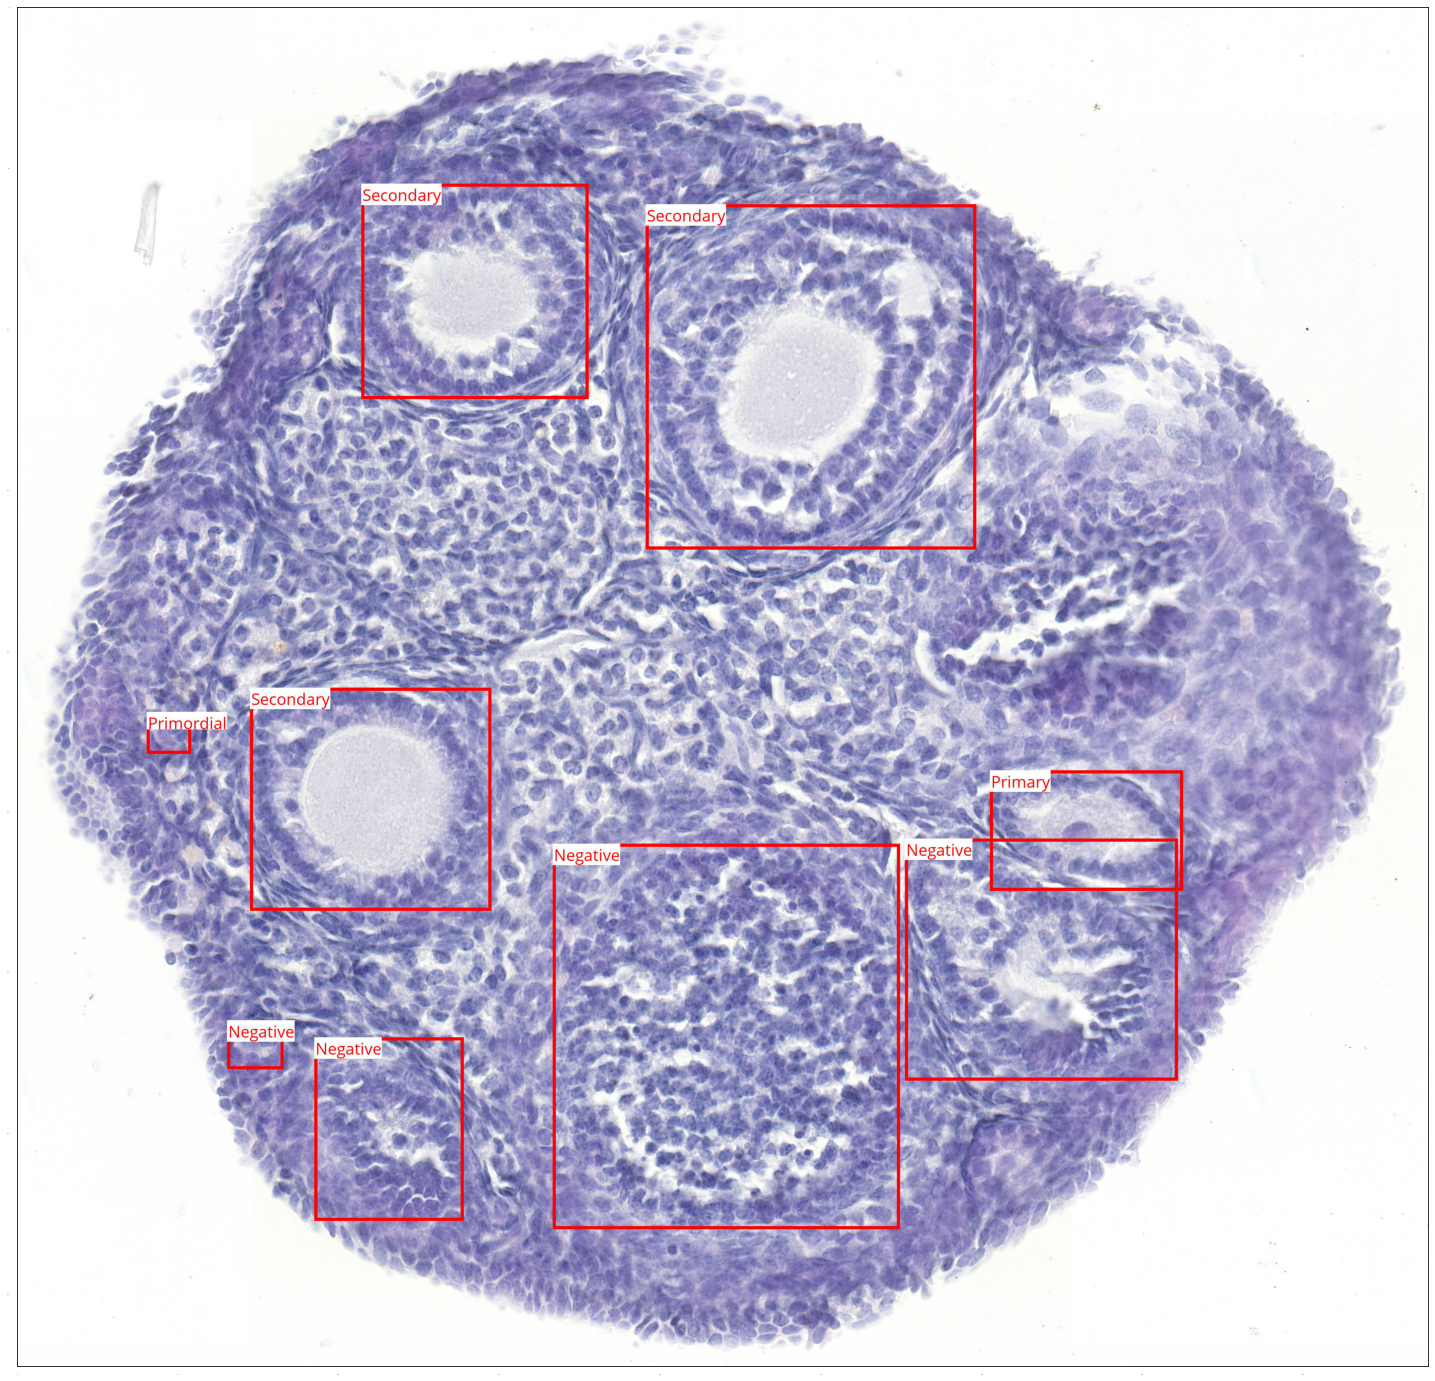

In [59]:


for idx, elem in enumerate(dataset_test):
    # Read and parse record
    parsed_example = parse_fn(elem)
    # Get im_width and im_height
    im_width = tf.sparse.to_dense(parsed_example['image/width']).numpy()[0]
    im_height = tf.sparse.to_dense(parsed_example['image/height']).numpy()[0]
    # Get label and bboxes coordinates
    labels = []
    for label in tf.sparse.to_dense(parsed_example['image/object/class/label']).numpy():
        labels.append(label)
    xmins = []
    for xmin in tf.sparse.to_dense(parsed_example['image/object/bbox/xmin']).numpy():
        xmins.append(xmin*im_width)
    ymins = []
    for ymin in tf.sparse.to_dense(parsed_example['image/object/bbox/ymin']).numpy():
        ymins.append(ymin*im_height)
    xmaxes = []
    for xmax in tf.sparse.to_dense(parsed_example['image/object/bbox/xmax']).numpy():
        xmaxes.append(xmax*im_width)
    ymaxes = []
    for ymax in tf.sparse.to_dense(parsed_example['image/object/bbox/ymax']).numpy():
        ymaxes.append(ymax*im_height)
    # Get texts
    texts = []
    for text in tf.sparse.to_dense(parsed_example['image/object/class/text']).numpy():
        text = text.decode('UTF-8')
        texts.append(text)
    # Convert encoded image to bytes then to JpegImageFile
    encoded_image = parsed_example['image/encoded']
    img_data = encoded_image.numpy()
    img = Image.open(BytesIO(img_data))
    # Draw image and bboxes
    draw = ImageDraw.Draw(img)
    for i in range(len(labels)):
        draw.rectangle((xmins[i], ymins[i], xmaxes[i], ymaxes[i]), outline="red", width=10)
    # Draw label text
    font = ImageFont.truetype("./OpenSans-Regular.ttf", 50)
    for i in range(len(labels)):
        w, h = font.getsize(texts[i])
        draw.rectangle((xmins[i], ymins[i], xmins[i] + w + 4, ymins[i] + h), fill="white")
        draw.text((xmins[i]+4, ymins[i]), texts[i], fill='red', font=font)
    # Display image
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        output_image = output.getvalue()
    image = Image.open(BytesIO(output_image))
    plt.subplot(1, 1, idx+1)
    plt.imshow(image)
plt.show()

# Training

In [2]:
import tensorflow as tf

BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [3]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

2021-10-06 14:29:50.243376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-06 14:29:50.243410: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-06 14:29:50.243428: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frcaud-Latitude-7420): /proc/driver/nvidia/version does not exist
2021-10-06 14:29:50.243688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    'train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)
class_names = train_dataset.class_names
print(class_names)

Found 258 files belonging to 3 classes.
['0_Primordial', '1_Primary', '2_Secondary']


In [5]:
test_dataset = image_dataset_from_directory(
    'test',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 31 files belonging to 3 classes.


In [6]:
val_dataset = image_dataset_from_directory(
    'val',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 63 files belonging to 3 classes.


In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2021-10-06 14:30:09.405149: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-06 14:30:09.422899: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1804800000 Hz


(10, 7, 7, 1280)


In [9]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 3)


In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843  

In [17]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
26/26 [==============================] - 5s 183ms/step - loss: 1.0408 - sparse_categorical_accuracy: 0.4884 - val_loss: 0.8327 - val_sparse_categorical_accuracy: 0.5873
Epoch 2/10
26/26 [==============================] - 5s 175ms/step - loss: 0.9583 - sparse_categorical_accuracy: 0.6008 - val_loss: 0.7385 - val_sparse_categorical_accuracy: 0.6508
Epoch 3/10
26/26 [==============================] - 6s 242ms/step - loss: 0.8635 - sparse_categorical_accuracy: 0.5891 - val_loss: 0.6749 - val_sparse_categorical_accuracy: 0.6825
Epoch 4/10
26/26 [==============================] - 7s 253ms/step - loss: 0.7387 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.6362 - val_sparse_categorical_accuracy: 0.7302
Epoch 5/10
26/26 [==============================] - 6s 216ms/step - loss: 0.6734 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.6012 - val_sparse_categorical_accuracy: 0.7619
Epoch 6/10
26/26 [==============================] - 6s 223ms/step - loss: 0.7014 - sparse_categorica

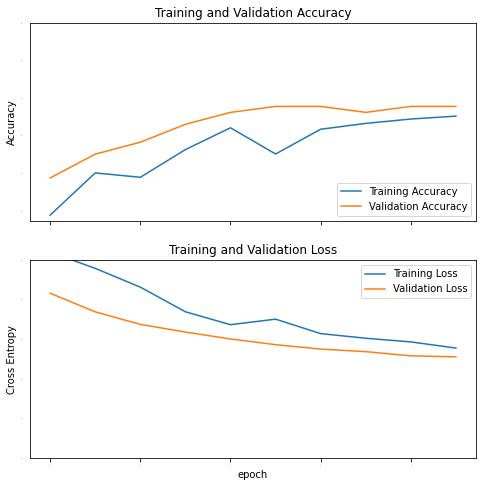

In [18]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = True
plt.rcParams['ytick.labelsize'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [8, 8]

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 85ms/step - loss: 0.5098 - sparse_categorical_accuracy: 0.8065
Test accuracy : 0.8064516186714172


In [20]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.where(predictions < 0.5, 0, 1)
predictions = np.argmax(predictions, axis=1)
print('predictions:',predictions)
print('truth:      ', label_batch)

predictions: [1 0 2 0 2 0 2 0 0 1]
truth:       [1 0 2 1 2 0 2 0 1 1]


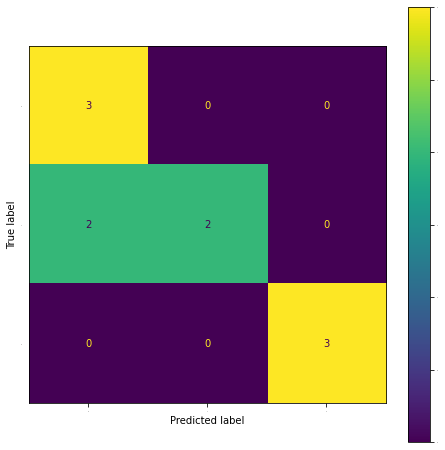

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(label_batch, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

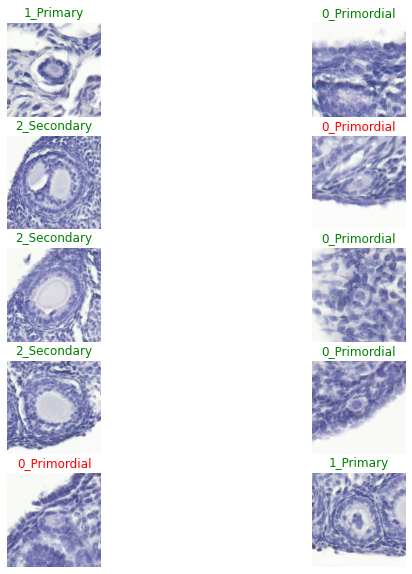

In [22]:
plt.figure(figsize=(10, 10))
for i in range(10):
  ax = plt.subplot(5, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  if predictions[i] != label_batch[i]:
    color = 'red'
  else:
    color = 'green'
  plt.title(class_names[predictions[i]], color=color)
  plt.axis("off")